In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH

%aimport models.base
%aimport models.AEFIT5
%aimport models.CAEFIT
%aimport models.CAEFIT1



import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u.npy'
if os.path.isfile(file):
    qsh.load(file)
else:
    qsh.load(ipysh.abs_builddir+'/te_db_1.npy')    
    qsh.rebalance_prel(15)
    qsh.save(ipysh.abs_builddir+'/te_db_r15u.npy')

In [7]:
qsh.shuffle()
# qsh.filter_number_set(15)
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()
# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive()

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [ ]:
# qsh.set_null(np.nan)
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive()
# qsh.set_null(np.nan)

## t-SNE Plot

In [ ]:
qsh.set_null(-1)
sne = Htls.tSNE()
# sne.perplexity = 50.
sne.random = 42

ds = qsh[range(0,4000)]
ds = np.concatenate([ds['prel'],ds['te']], axis=1)
# ds = np.array(list(zip(ds['prel'],ds['te'])))
sne(ds)

In [ ]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hsne.tSNE_PlotBokeh()
p.set_model(sne)
p.set_data(qsh, 1000)
p.plot(notebook_url='http://172.17.0.2:8888')

## VAE reconstruction - beta

The dropout has been set to 0. ... otherwise it seems to not converge ( tested with 0.4 )
Moreover also beta has been set to 0. ... that corresponds to a deterministic vae

In [94]:
# %aimport models.base
#%aimport models.AEFIT2
# %aimport models.AEFIT3
# q_vae = models.AEFIT2.AEFIT2(latent_dim=2, feature_dim=30, dprate=0., scale=4, beta=0.)
#q_vae = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=30, dprate=0., scale=1, beta=0.000001, geometry=[20,20,10,10])
q_vae = models.AEFIT5.AEFIT5(latent_dim=30, feature_dim=30, dprate=0., scale=1, beta=0.000001, geometry=[20,20,10,10])
# im1 = tf.keras.utils.plot_model(q_vae.inference_net, show_shapes=True, rankdir='LR')
# im2 = tf.keras.utils.plot_model(q_vae.generative_net, show_shapes=True, rankdir='LR')
# from IPython.display import display
# display(im1)
# display(im2)
# q_vae.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )
# q_vae.compile( tf.optimizers.Adam(1e-3), q_vae.compute_cross_entropy_loss )

AEFIT5 a ready:


In [8]:
p = Hplt.LSPlotBokeh()
p.set_model(q_vae)
p.set_data(qsh, counts=1000)
p.plot(notebook_url='http://172.17.0.2:8888')

/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/Hunch_lsplot.py:282: RuntimeWarning: invalid value encountered in true_divide
  return (data - m) / (M-m)


Loading BokehJS ...

In [95]:
ds = qsh.ds_array.map(lambda x,l: (x,x))

In [96]:
#models.base.manual_train_thread(q_vae, qsh, batch=200, epoch=6, loss_factor=1e-3)
# q_vae.train_thread(qsh, batch=200, epoch=10, learning_rate=1e-3).control_panel()
# models.base.train_thread(q_vae, qsh, batch=100, epoch=10, learning_rate=1e-3, callbacks=[]).control_panel()
def fun():
    global h
    h = q_vae.fit( ds.skip(3000).batch(100, drop_remainder=True), validation_data=ds.take(3000).batch(100), epochs=200, shuffle=False)
models.base.fn_thread(fn=fun, model=q_vae).control_panel()

Epoch 1/200
445/445 [==============================] - 13s 29ms/step - loss: 0.0023 - val_loss: 0.0000e+00
Epoch 2/200
445/445 [==============================] - 11s 24ms/step - loss: 3.6541e-04 - val_loss: 2.9585e-04
Epoch 3/200
445/445 [==============================] - 11s 24ms/step - loss: 2.7484e-04 - val_loss: 2.5100e-04
Epoch 4/200
445/445 [==============================] - 10s 23ms/step - loss: 2.5763e-04 - val_loss: 2.3335e-04
Epoch 5/200
445/445 [==============================] - 10s 23ms/step - loss: 2.4740e-04 - val_loss: 2.3224e-04
Epoch 6/200
445/445 [==============================] - 11s 24ms/step - loss: 2.2879e-04 - val_loss: 2.1819e-04
Epoch 7/200
445/445 [==============================] - 10s 23ms/step - loss: 2.0621e-04 - val_loss: 1.8521e-04
Epoch 8/200
445/445 [==============================] - 10s 23ms/step - loss: 1.6160e-04 - val_loss: 1.3516e-04
Epoch 9/200
445/445 [==============================] - 10s 23ms/step - loss: 1.3711e-04 - val_loss: 1.3504e-04
Epoch

445/445 [==============================] - 10s 23ms/step - loss: 4.6947e-05 - val_loss: 4.6415e-05
Epoch 75/200
445/445 [==============================] - 10s 23ms/step - loss: 4.6793e-05 - val_loss: 5.0418e-05
Epoch 76/200
445/445 [==============================] - 10s 23ms/step - loss: 4.6484e-05 - val_loss: 4.7661e-05
Epoch 77/200
445/445 [==============================] - 10s 23ms/step - loss: 4.6867e-05 - val_loss: 4.8179e-05
Epoch 78/200
445/445 [==============================] - 10s 23ms/step - loss: 4.6483e-05 - val_loss: 4.6680e-05
Epoch 79/200
445/445 [==============================] - 10s 23ms/step - loss: 4.6150e-05 - val_loss: 4.6536e-05
Epoch 80/200
445/445 [==============================] - 11s 24ms/step - loss: 4.6018e-05 - val_loss: 4.6464e-05
Epoch 81/200
445/445 [==============================] - 10s 23ms/step - loss: 4.6291e-05 - val_loss: 4.8027e-05
Epoch 82/200
445/445 [==============================] - 10s 23ms/step - loss: 4.7279e-05 - val_loss: 4.8329e-05
Epoch

Epoch 147/200
445/445 [==============================] - 10s 23ms/step - loss: 4.2212e-05 - val_loss: 4.4417e-05
Epoch 148/200
445/445 [==============================] - 10s 23ms/step - loss: 4.1934e-05 - val_loss: 4.6782e-05
Epoch 149/200
445/445 [==============================] - 10s 23ms/step - loss: 4.1768e-05 - val_loss: 4.5761e-05
Epoch 150/200
445/445 [==============================] - 10s 23ms/step - loss: 4.1637e-05 - val_loss: 4.5312e-05
Epoch 151/200
445/445 [==============================] - 10s 23ms/step - loss: 4.1384e-05 - val_loss: 4.4003e-05
Epoch 152/200
445/445 [==============================] - 10s 23ms/step - loss: 4.3192e-05 - val_loss: 4.6599e-05
Epoch 153/200
445/445 [==============================] - 10s 23ms/step - loss: 4.2321e-05 - val_loss: 4.5623e-05
Epoch 154/200
445/445 [==============================] - 10s 23ms/step - loss: 4.2242e-05 - val_loss: 4.5264e-05
Epoch 155/200
445/445 [==============================] - 10s 23ms/step - loss: 4.1560e-05 - val_

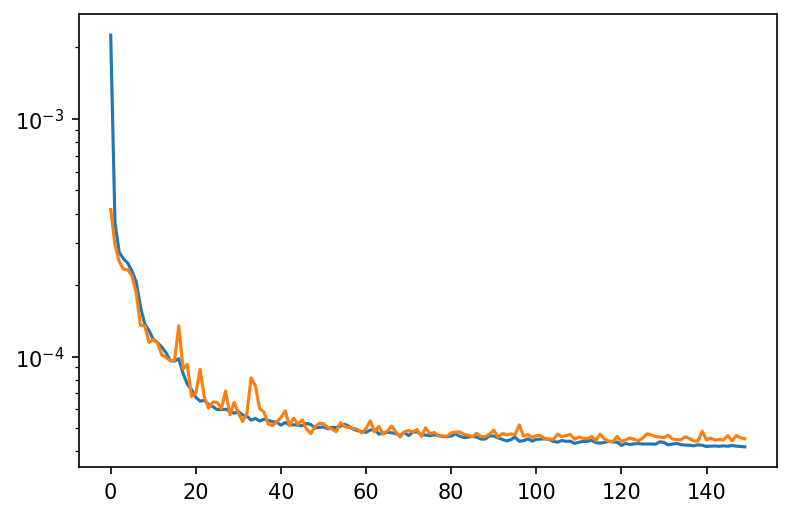

In [98]:
loss = [i[0] for i in h.history['loss']]
val_loss = [i[0] for i in h.history['val_loss']]
fig = plt.figure('loss')
fig.set_dpi(150)
plt.yscale('log')
plt.plot(loss[0:150])
plt.plot(val_loss[0:150])

In [ ]:
# q_vae.save('step7_beta0_r15_1')
q_vae.save('step7_beta0001_r15_ls2_1')

In [9]:
# q_vae.load('step7_beta0_r15_1')
q_vae.load('step7_beta0001_r15_ls2_1')

/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/Hunch_lsplot.py:282: RuntimeWarning: invalid value encountered in true_divide
  return (data - m) / (M-m)


In [19]:
# extract few points curve
import copy

qsh2 = Dataset_QSH.Dataset_QSH()
qsh2.load(ipysh.abs_builddir+'/te_db_r15u.npy')
qsh2.dim = 15
qsh2.set_null(np.nan)
qsh2.set_normal_positive()
# qsh2.unbias_mean(0.5, 'te')
# qsh2.set_normal_positive()
qsh2.set_null(np.nan)
# qsh2.clip_values(0.1,0.6)
# qsh2.set_normal_positive()

qsh2.filter_number_set(5)
qsh2.dim = 15




In [99]:
pos = 25
pos = 39

39


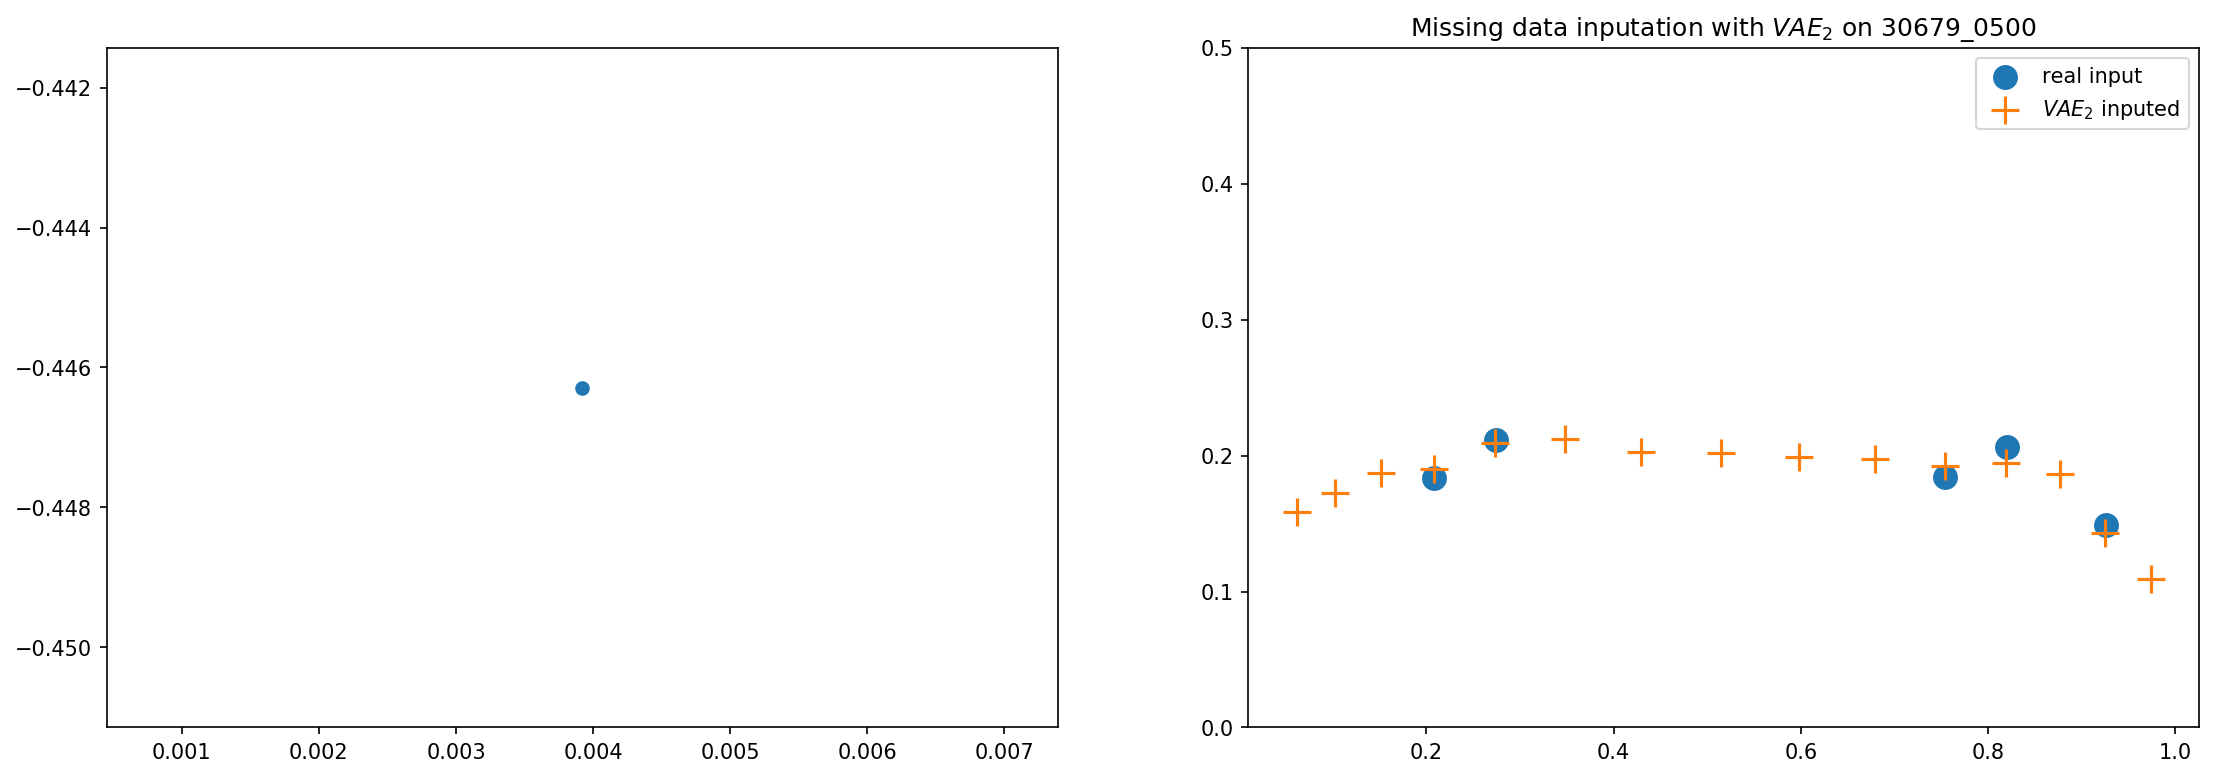

In [100]:

fig = plt.figure('gen_missing_curve',figsize=(18, 6))
fig.set_dpi(150)
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,0.5)

# print(q_vae.apply_sigmoid)
print(pos)
# qsh2.shuffle()
for xy in qsh2.ds_array.skip(pos).batch(1).take(1):
    ax2.set_title('Missing data inputation with $VAE_2$ on %s'%qsh2[pos].label.decode("utf-8") )
    xy,_ = xy
    # print(xy)
    x,y = tf.split(xy[0],2)
    ax2.scatter(x,y,s=120, label='real input')
    m,v  = q_vae.encode(xy, training=False)    
    gpt = m[0].numpy()
    # print(gpt)
    ax1.scatter(gpt[0],gpt[1])

    XY = q_vae.decode(m, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())

    ax2.scatter(X,Y,s=180, marker='+', label='$VAE_2$ inputed')
    ax2.legend()
pos += 1


# CLEAN DATABASE

In [ ]:
## CLEAN QSH DATABASE
import copy
from tqdm import tqdm
qsh_clean = copy.deepcopy(qsh)

print( q_vae.apply_sigmoid )

ds = qsh.ds_array
for i,X in enumerate(tqdm(ds.batch(1), total=len(qsh))):
    X,_ = X
    s   = int(q_vae.feature_dim/2)
    Xr  = q_vae.recover(X)
    x,y = tf.split(Xr, 2, axis=1)
    qsh_clean[i].prel[:s] = x
    qsh_clean[i].te[:s]   = y

    


In [ ]:
qsh_clean.save(ipysh.abs_builddir+'/te_db_r15_clean.npy')

In [ ]:
qsh_clean = Htls.QSH_Dataset()
qsh_clean.load(ipysh.abs_builddir+'/te_db_r15_clean.npy')
qsh_clean.dim = 15
qsh_clean.set_null(np.nan)

## TSNE on clean

In [ ]:
qsh_clean.set_null(-1)
sne = Htls.tSNE()
# sne.perplexity = 50.
sne.random = 42

ds = qsh_clean[0:2000]
ds = np.concatenate([ds['prel'],ds['te']], axis=1)
sne(ds)

In [ ]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hsne.tSNE_PlotBokeh()
p.set_model(sne)
p.set_data(qsh_clean, 1000)
p.plot(notebook_url='http://172.17.0.2:8888')

# CONVOLUTIONAL VAE

In [ ]:
cae = models.CAEFIT.CAEFIT(latent_dim=2, feature_dim=30, dprate=0., scale=2, beta=0.)

# im1 = tf.keras.utils.plot_model(cae.inference_net, show_shapes=True, rankdir='LR')
# im2 = tf.keras.utils.plot_model(cae.generative_net, show_shapes=True, rankdir='LR')
# from IPython.display import display
# display(im1)
# display(im2)

In [ ]:
cae = models.CAEFIT1.CAEFIT1(latent_dim=2, feature_dim=30, dprate=0., scale=2, beta=0.)

In [ ]:
ds = qsh_clean.ds_array
ds0,_ = [x for x in ds.take(1).batch(1)][0]
ds0
me,va = cae.encode(ds0)
y = cae.decode(me, apply_sigmoid=True)
y

In [ ]:
# train(cae, qsh_clean, batch=200, epoch=10, loss_factor=1e-4)
# models.base.train(cae, qsh_clean, batch=200, epoch=2, loss_factor=1e-3)
models.base.train(cae, qsh_clean, batch=200, epoch=2, loss_factor=1e-3)

In [ ]:
models.base.train_thread(cae, qsh_clean, batch=200, epoch=5, learning_rate=1e-3).control_panel()

In [ ]:
# ipysh.Bootstrap_support.debug()

p = Hplt.LSPlotBokeh()
p.set_model(cae)
p.set_data(qsh_clean, counts=1000)
p.plot_notebook(notebook_url='http://172.17.0.2:8888')

In [ ]:
# cae.save('step7_cae_r15')

In [ ]:
cae.load('step7_cae_r15')

In [ ]:
qsh_pos = 0

In [ ]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)


for xy in qsh_clean.ds_array.skip(qsh_pos).take(1):    
    xy,_ = xy
    x,y = tf.split(xy,2)
    ax2.scatter(x,y,s=80)
    m,v  = cae.encode([xy], training=False)
    gpt = m[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = cae.decode(m,apply_sigmoid=True, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1
